In [1]:
import tomli
import shutil
import os
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
import delu as zero

In [2]:
sys.path.append('/home/sebastian/Documents/programs/pythonProject/tab-ddpm/')

In [3]:
from tab_ddpm.scripts.train import train as _train
from tab_ddpm.scripts.sample import sample as _sample
from tab_ddpm.tab_ddpm.gaussian_multinomial_diffsuion import GaussianMultinomialDiffusion
from tab_ddpm.scripts.utils_train import get_model, make_dataset
from tab_ddpm import lib

In [4]:
DEFAULT_DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [5]:
def load_config(path) :
    with open(path, 'rb') as f:
        return tomli.load(f)
    
def save_file(parent_dir, config_path):
    try:
        dst = os.path.join(parent_dir)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copyfile(os.path.abspath(config_path), dst)
    except shutil.SameFileError:
        pass

In [6]:
config_file_path = './exp/poly_lines/config.toml'
raw_config = lib.load_config(config_file_path)

device = DEFAULT_DEVICE

save_file(os.path.join(raw_config['parent_dir'], 'config.toml'), config_file_path)

# Train network

In [7]:
%%time
_train(
    **raw_config['train']['main'],
    **raw_config['diffusion_params'],
    parent_dir=raw_config['parent_dir'],
    real_data_path=raw_config['real_data_path'],
    model_type=raw_config['model_type'],
    model_params=raw_config['model_params'],
    T_dict=raw_config['train']['T'],
    num_numerical_features=raw_config['num_numerical_features'],
    device=device,
    change_val=False
)

/Users/ratzenboe/anaconda3/envs/torch/lib/python3.11/site-packages/delu/_utils.py:22: DeLUDeprecationWarning: The function improve_reproducibility` is deprecated and will be removed in future releases. Instead, use `delu.random.seed` and manually set flags mentioned in the `PyTorch docs on reproducibility <https://pytorch.org/docs/stable/notes/randomness.html>`_
  warnings.warn(


[0]
2
{'d_in': 2, 'num_classes': 2, 'is_y_cond': True, 'rtdl_params': {'d_layers': [256, 1024, 1024, 512], 'dropout': 0.0}}
mlp
Step 10/3000 MLoss: 0.0 GLoss: 0.7287 Sum: 0.7287
Step 20/3000 MLoss: 0.0 GLoss: 0.6206 Sum: 0.6206
Step 30/3000 MLoss: 0.0 GLoss: 0.5441 Sum: 0.5441
Step 40/3000 MLoss: 0.0 GLoss: 0.5299 Sum: 0.5299
Step 50/3000 MLoss: 0.0 GLoss: 0.4955 Sum: 0.4955
Step 60/3000 MLoss: 0.0 GLoss: 0.5062 Sum: 0.5062
Step 70/3000 MLoss: 0.0 GLoss: 0.4733 Sum: 0.4733
Step 80/3000 MLoss: 0.0 GLoss: 0.4986 Sum: 0.4986
Step 90/3000 MLoss: 0.0 GLoss: 0.5035 Sum: 0.5035
Step 100/3000 MLoss: 0.0 GLoss: 0.4768 Sum: 0.4768
Step 110/3000 MLoss: 0.0 GLoss: 0.4979 Sum: 0.4979
Step 120/3000 MLoss: 0.0 GLoss: 0.4846 Sum: 0.4846
Step 130/3000 MLoss: 0.0 GLoss: 0.4893 Sum: 0.4893
Step 140/3000 MLoss: 0.0 GLoss: 0.4914 Sum: 0.4914
Step 150/3000 MLoss: 0.0 GLoss: 0.4843 Sum: 0.4843
Step 160/3000 MLoss: 0.0 GLoss: 0.4721 Sum: 0.4721
Step 170/3000 MLoss: 0.0 GLoss: 0.4807 Sum: 0.4807
Step 180/3000 

# Plot data

In [8]:
X_train = np.load(os.path.join(raw_config['real_data_path'], 'X_num_train.npy'))

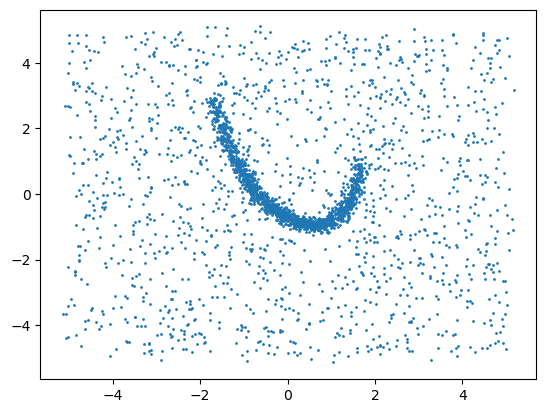

In [9]:
plt.scatter(X_train[:, 0], X_train[:, 1], s=1);

# Sampling

In [10]:
# Set necessary parameters
real_data_path = raw_config['real_data_path']
batch_size = raw_config['sample']['batch_size']
num_samples = raw_config['sample']['num_samples']
model_type = raw_config['model_type']
model_params = raw_config['model_params']
model_path = os.path.join(raw_config['parent_dir'], 'model.pt')
num_timesteps = 1000
gaussian_loss_type = 'mse'
scheduler = 'cosine'
T_dict = raw_config['train']['T']
num_numerical_features = raw_config['num_numerical_features'] 
disbalance = raw_config['sample'].get('disbalance', None)
seed = raw_config['sample'].get('seed', 0)
change_val = False

zero.improve_reproducibility(seed)
# Get data
T = lib.Transformations(**T_dict)
D = make_dataset(
    real_data_path,
    T,
    num_classes=model_params['num_classes'],
    is_y_cond=model_params['is_y_cond'],
    change_val=change_val
)

K = np.array(D.get_category_sizes('train'))
if len(K) == 0 or T_dict['cat_encoding'] == 'one-hot':
    K = np.array([0])

num_numerical_features_ = D.X_num['train'].shape[1] if D.X_num is not None else 0
d_in = np.sum(K) + num_numerical_features_
model_params['d_in'] = int(d_in)

/Users/ratzenboe/anaconda3/envs/torch/lib/python3.11/site-packages/delu/_utils.py:22: DeLUDeprecationWarning: The function improve_reproducibility` is deprecated and will be removed in future releases. Instead, use `delu.random.seed` and manually set flags mentioned in the `PyTorch docs on reproducibility <https://pytorch.org/docs/stable/notes/randomness.html>`_
  warnings.warn(


In [11]:
# Get denoising model (MLPDiffusion model)
model = get_model(
    model_type,
    model_params,
    num_numerical_features_,
    category_sizes=D.get_category_sizes('train')
)
model.load_state_dict(
    torch.load(model_path, map_location="cpu")
)
# Create instance of diffusion model
diffusion = GaussianMultinomialDiffusion(
    num_classes=K,
    num_numerical_features=num_numerical_features_,
    denoise_fn=model, 
    num_timesteps=num_timesteps, 
    gaussian_loss_type=gaussian_loss_type, 
    scheduler=scheduler, 
    device=device
)
diffusion.to(device)
diffusion.eval()
# 
_, empirical_class_dist = torch.unique(torch.from_numpy(D.y['train']), return_counts=True)
# Generate data
x_gen, y_gen = diffusion.sample_all(num_samples, batch_size, empirical_class_dist.float(), ddim=False)
X_gen, y_gen = x_gen.numpy(), y_gen.numpy()

num_numerical_features = num_numerical_features + int(D.is_regression and not model_params["is_y_cond"])
# Get numerical features
X_num_ = D.num_transform.inverse_transform(X_gen[:, :num_numerical_features])
X_num = X_num_[:, :num_numerical_features]

mlp
Sample timestep    0
Sample timestep    0
Sample timestep    0
Sample timestep    0


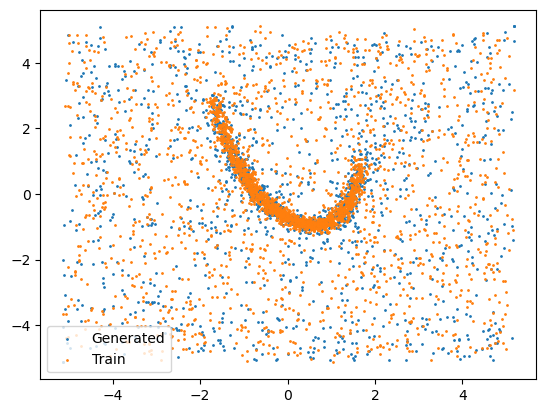

In [12]:
# Plot generated data
plt.scatter(X_num[:, 0], X_num[:, 1], s=1, label='Generated')
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, label='Train')
plt.legend()

In [13]:
# Generate samples at each timestep
@torch.no_grad()
def diffused_samples(diffusion_model, num_samples, y_dist):
    b = num_samples
    device = diffusion_model.log_alpha.device
    z_norm = torch.randn((b, diffusion_model.num_numerical_features), device=device)
    # Create y
    y = torch.multinomial(
        y_dist,
        num_samples=b,
        replacement=True
    )
    samples_t_i = []  
    out_dict = {'y': y.long().to(device)}
    for i in reversed(range(0, diffusion_model.num_timesteps)):
        print(f'Sample timestep {i:4d}', end='\r')
        t = torch.full((b,), i, device=device, dtype=torch.long)
        model_out = diffusion_model._denoise_fn(
            torch.cat([z_norm], dim=1).float(),
            t,
            **out_dict
        )
        model_out_num = model_out[:, :diffusion_model.num_numerical_features]
        z_norm = diffusion_model.gaussian_p_sample(model_out_num, z_norm, t, clip_denoised=False)['sample']
        sample = torch.cat([z_norm], dim=1)
        mask_nan = torch.any(sample.isnan(), dim=1)
        sample = sample[~mask_nan]
        samples_t_i.append(sample.numpy())
        
    print()
    return samples_t_i

In [14]:
# Get samples at each timestep
samples_t_i = diffused_samples(diffusion, batch_size, empirical_class_dist.float())

Sample timestep    0


In [15]:
# Get transformed samples (inverse quantile transform, see config.toml for transformation parameters)
samples_t_i_final = [D.num_transform.inverse_transform(si) for si in samples_t_i]

In [17]:
for i in range(len(samples_t_i_final)):
    if i%10 == 0:
        plt.scatter(samples_t_i_final[i][:, 0], samples_t_i_final[i][:, 1], s=1)
        # save fig on Desktop
        plt.savefig(f'/Users/ratzenboe/Desktop/figs/fig_t-{i}.png')  #, tight_layout=True)
        plt.close()
        
plt.scatter(samples_t_i_final[-1][:, 0], samples_t_i_final[-1][:, 1], s=1)
# save fig on Desktop
plt.savefig(f'/Users/ratzenboe/Desktop/figs/fig_t-{1000}.png')  #, tight_layout=True)
plt.close()